In [1]:
import sys
sys.path.insert(1, '/home/yannik/vssil')

import matplotlib.pyplot as plt
import pylab
import torch
from torch.nn import KLDivLoss
from torchvision.io import read_video
from scipy.special import kl_div

from src.utils.kpt_utils import get_image_patches, kpts_2_img_coordinates
from contrastive_loss_test_data.test_data import load_sample_images
from contrastive_loss_test_data.test_keypoints import get_perfect_keypoints, get_bad_keypoints, get_random_keypoints

In [2]:
torch.manual_seed(123)

sample_size = 4
batch_size = 16

img_tensor = load_sample_images(sample_size=sample_size,
                                path="/home/yannik/vssil/contrastive_loss_test_data/990000.mp4").unsqueeze(0)
img_tensor = img_tensor.repeat((batch_size, 1, 1, 1, 1))
N, T, C, H, W = img_tensor.shape

time_window = 5
patch_size = (35, 35)

pos_range = max(int(time_window / 2), 1) if time_window > 1 else 0
center_index = int(patch_size[0] / 2)

step_matrix = torch.ones(patch_size + (2,))

step_w = 2 / W
step_h = 2 / H

for k in range(0, patch_size[0]):
    for l in range(0, patch_size[1]):
        step_matrix[k, l, 0] = (l - center_index) * step_w
        step_matrix[k, l, 1] = (k - center_index) * step_h
        

hist_norm_p = float('inf')  # 0, 1, 2, float('inf')
v_max = 500
n_bins = 32  # 100

In [3]:
perfect_kpt_coordinates = get_perfect_keypoints(T=sample_size).unsqueeze(0)
perfect_kpt_coordinates = perfect_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = perfect_kpt_coordinates.shape

perfect_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=perfect_kpt_coordinates[0:1, ...],
                                        patch_size=(32, 32)).repeat((N, 1, 1, 1, 1, 1))

N, T, K, C, Hp, Wp  = perfect_kpt_patches.shape

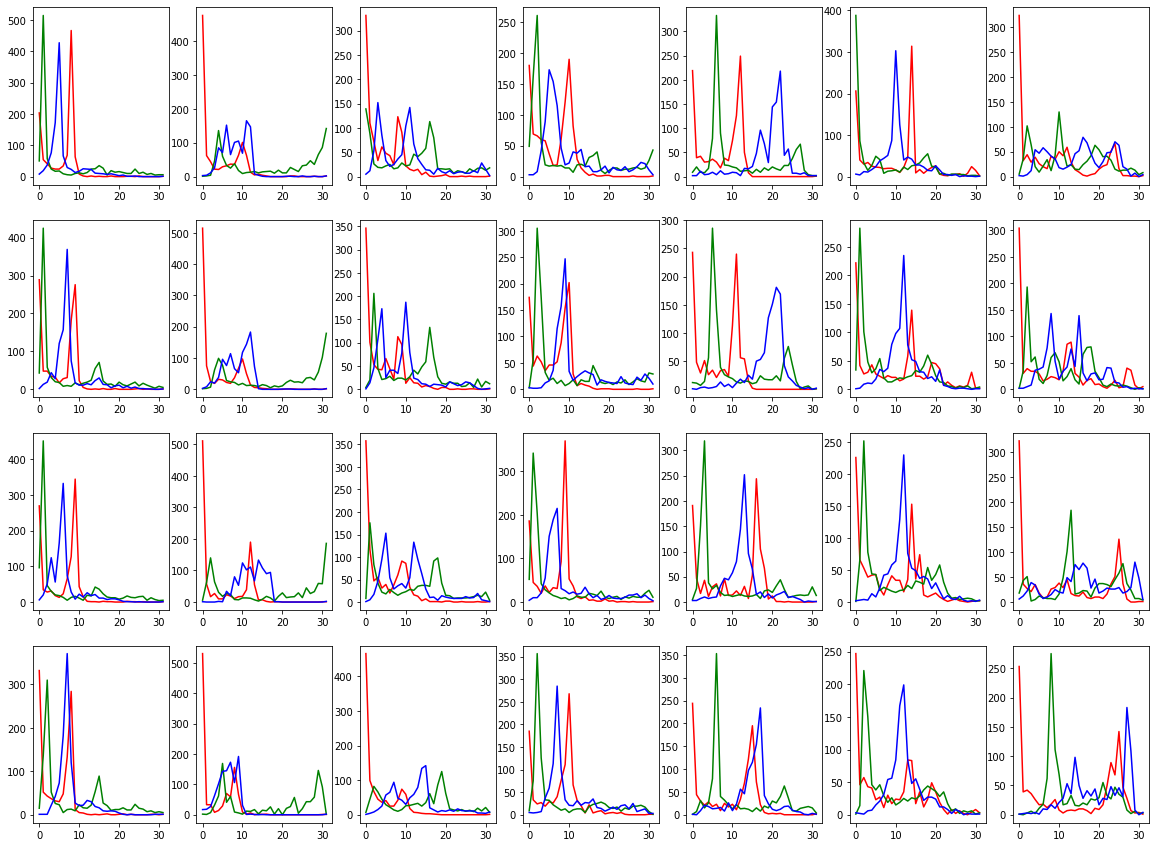

In [4]:
import numpy as np

perfect_hists = torch.empty((N, T, K, C, n_bins))
for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                perfect_hists[n, t, k, c] = torch.histc(perfect_kpt_patches[n, t, k, c], bins=n_bins)

fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), perfect_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), perfect_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), perfect_hists[0, t, k, 2], color='blue')
    

tensor([[340.,  76., 180., 228., 207., 354., 102.],
        [295., 176., 156., 286., 305., 217., 145.],
        [332., 184., 131., 267., 320.,  72., 268.]])
tensor(221.)


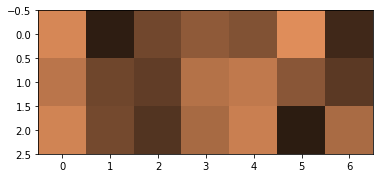

In [5]:
perfect_dist = torch.empty((K, T-1))

dkl = KLDivLoss(reduction='batchmean')

for k in range(K):
    for t in range(T-1):
        #perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        perfect_dist[k, t] = torch.norm(perfect_hists[0, t:t+1, k, :] - perfect_hists[0, t+1:t+2, k, :], p=hist_norm_p)

print(perfect_dist.T)
        
plt.imshow(perfect_dist.T.cpu().numpy(), cmap='copper', vmin=0, vmax=v_max)

print(perfect_dist.mean())

In [6]:
bad_kpt_coordinates = get_bad_keypoints(T=sample_size).unsqueeze(0)
bad_kpt_coordinates = bad_kpt_coordinates.repeat((batch_size, 1, 1, 1))

bad_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=bad_kpt_coordinates[0:1, ...],
                                        patch_size=(32, 32)).repeat((N, 1, 1, 1, 1, 1))


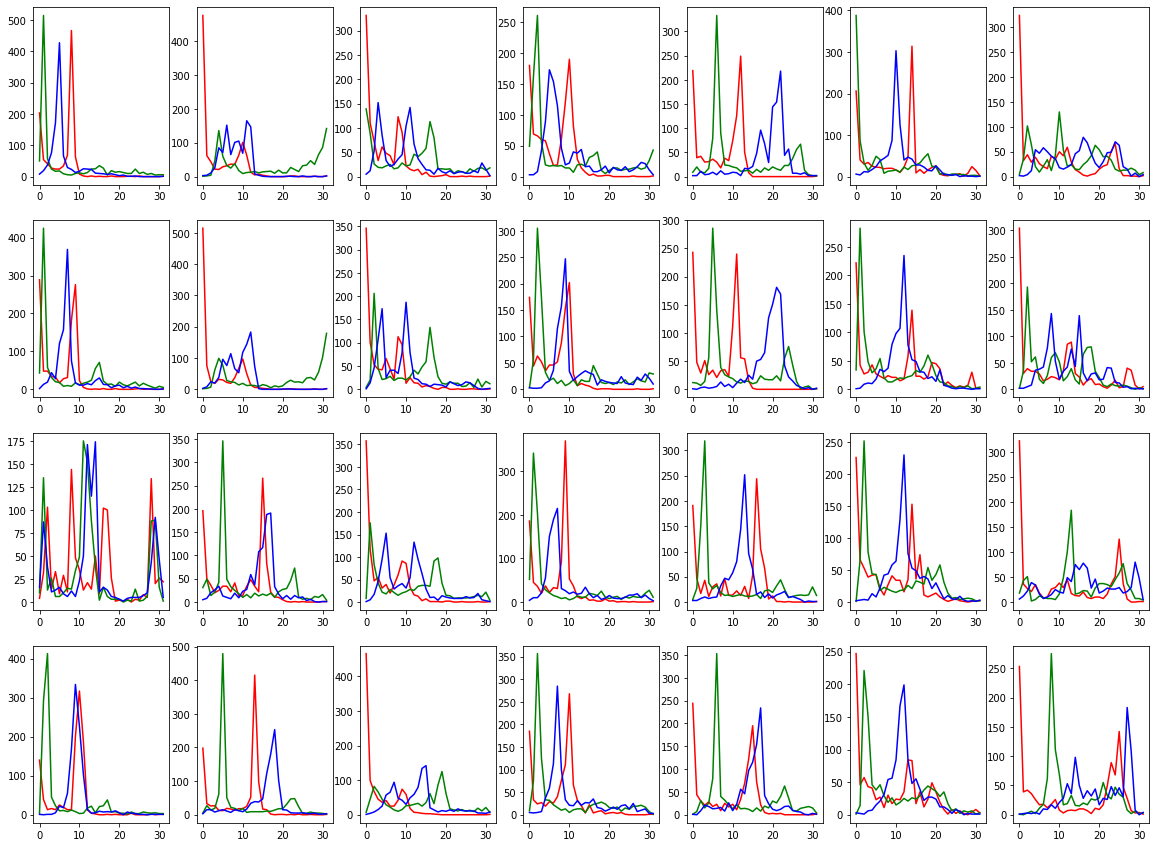

In [7]:
bad_hists = torch.empty((N, T, K, C, n_bins))
for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                bad_hists[n, t, k, c] = torch.histc(bad_kpt_patches[n, t, k, c], bins=n_bins)

fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), bad_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), bad_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), bad_hists[0, t, k, 2], color='blue')

tensor([[340.,  76., 180., 228., 207., 354., 102.],
        [363., 319., 156., 286., 305., 217., 145.],
        [400., 381., 131., 267., 320.,  72., 268.]])
tensor(243.6667)


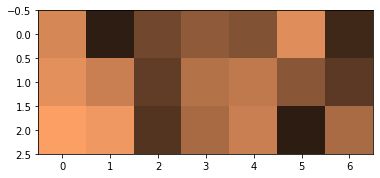

In [8]:
bad_dist = torch.empty((K, T-1))

dkl = KLDivLoss(reduction='batchmean')

for k in range(K):
    for t in range(T-1):
        #bad_dist[k, t] = dkl(bad_hists[0, t:t+1, k, :], bad_hists[0, t+1:t+2, k, :])
        bad_dist[k, t] = torch.norm(bad_hists[0, t:t+1, k, :] - bad_hists[0, t+1:t+2, k, :], p=hist_norm_p)

print(bad_dist.T)
        
plt.imshow(bad_dist.T.cpu().numpy(), cmap='copper', vmin=0, vmax=v_max)

print(bad_dist.mean())

In [9]:
random_kpt_coordinates = get_random_keypoints(T=sample_size).unsqueeze(0)
random_kpt_coordinates = random_kpt_coordinates.repeat((batch_size, 1, 1, 1))

random_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=random_kpt_coordinates[0:1, ...],
                                        patch_size=(32, 32)).repeat((N, 1, 1, 1, 1, 1))

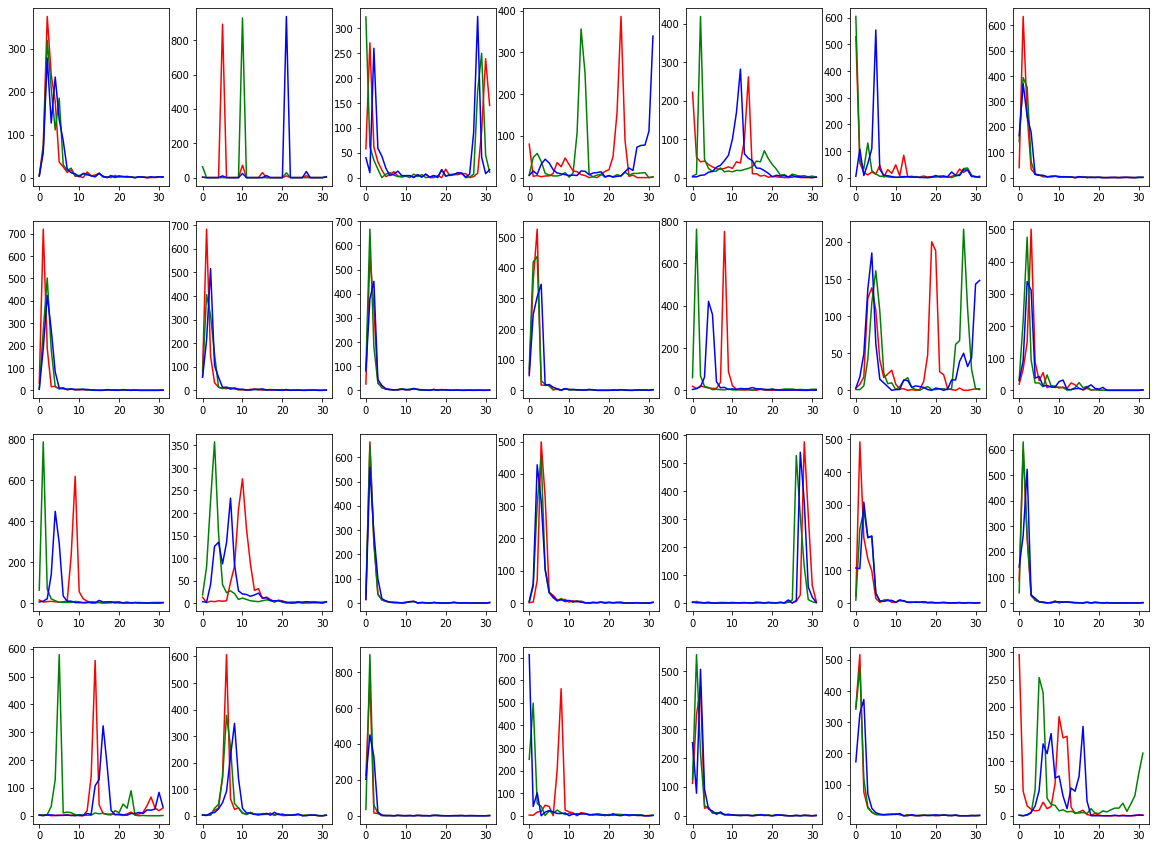

In [10]:
random_hists = torch.empty((N, T, K, C, n_bins))
for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                random_hists[n, t, k, c] = torch.histc(random_kpt_patches[n, t, k, c], bins=n_bins)

fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), random_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), random_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), random_hists[0, t, k, 2], color='blue')

tensor([[644., 935., 605., 521., 753., 604., 569.],
        [715., 682., 180., 482., 760., 484., 534.],
        [784., 602., 245., 709., 574., 333., 630.]])
tensor(587.8571)


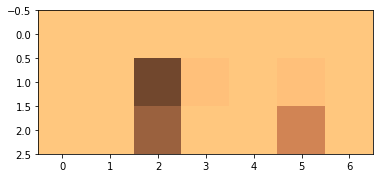

In [11]:
random_dist = torch.empty((K, T-1))

dkl = KLDivLoss(reduction='batchmean')

for k in range(K):
    for t in range(T-1):
        #bad_dist[k, t] = dkl(bad_hists[0, t:t+1, k, :], bad_hists[0, t+1:t+2, k, :])
        random_dist[k, t] = torch.norm(random_hists[0, t:t+1, k, :] - random_hists[0, t+1:t+2, k, :], p=hist_norm_p)

print(random_dist.T)
        
plt.imshow(random_dist.T.cpu().numpy(), cmap='copper', vmin=0, vmax=v_max)

print(random_dist.mean())

Tensor based loss formulation

In [12]:
H_t_perfect = perfect_hists.unsqueeze(1) - perfect_hists.unsqueeze(2)
H_t_perfect = torch.norm(H_t_perfect, p=float('inf'), dim=[-1, -2]).permute(0, 3, 1, 2)
H_t_perfect = torch.sum(H_t_perfect, dim=[-1, -2]) / (T*(T-1))
print(torch.mean(H_t_perfect))

tensor(230.0714)


In [13]:
H_t_bad = bad_hists.unsqueeze(1) - bad_hists.unsqueeze(2)
H_t_bad = torch.norm(H_t_bad, p=float('inf'), dim=[-1, -2]).permute(0, 3, 1, 2)
H_t_bad = torch.sum(H_t_bad, dim=[-1, -2]) / (T*(T-1))
print(torch.mean(H_t_bad))

tensor(260.5714)


In [14]:
H_t_random = random_hists.unsqueeze(1) - random_hists.unsqueeze(2)
H_t_random = torch.norm(H_t_random, p=float('inf'), dim=[-1, -2]).permute(0, 3, 1, 2)
H_t_random = torch.sum(H_t_random, dim=[-1, -2]) / (T*(T-1))
print(torch.mean(H_t_random))

tensor(604.6904)
